<a href="https://colab.research.google.com/github/SeanaMutinda/FUTURE_ML_02/blob/main/Ticket_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Support Ticket Classification & Prioritization System
======================================================

An intelligent ML system that automatically:
1. Classifies support tickets into categories
2. Assigns priority levels (High/Medium/Low)
3. Helps support teams respond faster and more efficiently

This system is used in real SaaS companies, help desks, and IT support operations.

Author: Seana Mutinda
Organization: Future Interns ML Task 2 (2026)

In [1]:
import pandas as pd
import numpy as np
import re
import json
from collections import Counter
import pickle
from typing import List, Dict, Tuple
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adisongoh/it-service-ticket-classification-dataset")

print("Path to dataset files:", path)

100%|██████████| 3.45M/3.45M [00:00<00:00, 4.03MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adisongoh/it-service-ticket-classification-dataset/versions/1


In [2]:
# STEP 1: Load Dataset from Kaggle

import pandas as pd
import os

# 'path' variable is available from the previous cell's execution, which is: '/kaggle/input/it-service-ticket-classification-dataset'

# List the contents of the downloaded directory to identify the correct file name
print(f"Contents of the downloaded directory '{path}':")
for root, dirs, files in os.walk(path):
    for name in files:
        print(os.path.join(root, name))
    for name in dirs:
        print(os.path.join(root, name))

# Update file_path_in_dataset with the correct file name once identified
file_path_in_dataset = "all_tickets_processed_improved_v3.csv"

# Construct the full path to the CSV file
full_csv_path = os.path.join(path, file_path_in_dataset)

# Only attempt to read if the file is confirmed to exist
if os.path.exists(full_csv_path):
    df = pd.read_csv(full_csv_path)

    print("Dataset loaded!")
    print(f"Shape: {df.shape}")
    print(df.head())
else:
    print(f"Error: The file '{file_path_in_dataset}' was not found in '{path}'. Please check the printed directory contents for the correct file name.")

Contents of the downloaded directory '/root/.cache/kagglehub/datasets/adisongoh/it-service-ticket-classification-dataset/versions/1':
/root/.cache/kagglehub/datasets/adisongoh/it-service-ticket-classification-dataset/versions/1/all_tickets_processed_improved_v3.csv
Dataset loaded!
Shape: (47837, 2)
                                            Document    Topic_group
0  connection with icon icon dear please setup ic...       Hardware
1  work experience user work experience user hi w...         Access
2  requesting for meeting requesting meeting hi p...       Hardware
3  reset passwords for external accounts re expir...         Access
4  mail verification warning hi has got attached ...  Miscellaneous


In [3]:
# STEP 2: Data Cleaning and Wrangling

print("\n" + "="*80)
print("DATA CLEANING AND WRANGLING")
print("="*80)

# Check for missing values
print("\nMissing Values Before Cleaning:")
print(df.isnull().sum())

# Remove rows with missing values in critical columns
df = df.dropna(subset=['Document', 'Topic_group'])

print("\nMissing Values After Dropping:")
print(df.isnull().sum())

# Remove duplicate rows
print(f"\nDuplicates before removal: {df.duplicated().sum()}")
df = df.drop_duplicates()
print(f"Duplicates after removal: {df.duplicated().sum()}")

# Remove rows with empty strings
df = df[df['Document'].str.strip() != '']
df = df[df['Topic_group'].str.strip() != '']

# Reset index
df = df.reset_index(drop=True)

print(f"\nDataset shape after cleaning: {df.shape}")
print(f"Cleaned dataset contains {len(df)} records")


DATA CLEANING AND WRANGLING

Missing Values Before Cleaning:
Document       0
Topic_group    0
dtype: int64

Missing Values After Dropping:
Document       0
Topic_group    0
dtype: int64

Duplicates before removal: 0
Duplicates after removal: 0

Dataset shape after cleaning: (47837, 2)
Cleaned dataset contains 47837 records


In [4]:
# STEP 3: Exploratory Data Analysis (EDA)

print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS (EDA)")
print("="*80)

# Basic dataset info
print("\nDataset Info:")
print(df.info())

# Display data types
print("\nData Types:")
print(df.dtypes)

# Statistical summary
print("\nStatistical Summary:")
print(df.describe())

# Target variable distribution
print("\nTarget Variable Distribution (Topic_group):")
print(df['Topic_group'].value_counts())
print(f"\nTotal unique categories: {df['Topic_group'].nunique()}")

# Percentage distribution
print("\nPercentage Distribution:")
print((df['Topic_group'].value_counts() / len(df) * 100).round(2))

# Text length analysis
df['text_length'] = df['Document'].str.len()
df['word_count'] = df['Document'].str.split().str.len()

print("\nText Length Statistics:")
print(f"Min length: {df['text_length'].min()}")
print(f"Max length: {df['text_length'].max()}")
print(f"Mean length: {df['text_length'].mean():.2f}")
print(f"Median length: {df['text_length'].median():.2f}")

print("\nWord Count Statistics:")
print(f"Min words: {df['word_count'].min()}")
print(f"Max words: {df['word_count'].max()}")
print(f"Mean words: {df['word_count'].mean():.2f}")
print(f"Median words: {df['word_count'].median():.2f}")

# Check for null values in text
print(f"\nNull values in Document: {df['Document'].isnull().sum()}")
print(f"Null values in Topic_group: {df['Topic_group'].isnull().sum()}")

# Distribution across categories
print("\nRecords per Category:")
category_counts = df['Topic_group'].value_counts().sort_values(ascending=False)
for category, count in category_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {category}: {count} ({percentage:.2f}%)")

# Check for class imbalance
print("\nClass Balance Check:")
min_samples = df['Topic_group'].value_counts().min()
max_samples = df['Topic_group'].value_counts().max()
imbalance_ratio = max_samples / min_samples
print(f"Most common class samples: {max_samples}")
print(f"Least common class samples: {min_samples}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 3:
    print("WARNING: Dataset shows significant class imbalance (>3:1 ratio)")
else:
    print("Dataset has reasonable class balance")

# Display sample documents from each category
print("\nSample Documents from Each Category:")
for category in df['Topic_group'].unique()[:3]:
    sample_doc = df[df['Topic_group'] == category]['Document'].iloc[0][:100]
    print(f"\n{category}:")
    print(f"  {sample_doc}...")

# Check for special characters and patterns
print("\nText Characteristics:")
has_numbers = df['Document'].str.contains(r'\d', regex=True).sum()
has_special = df['Document'].str.contains(r'[^a-zA-Z0-9\s]', regex=True).sum()
has_urls = df['Document'].str.contains(r'http|www', regex=True).sum()
has_emails = df['Document'].str.contains(r'\S+@\S+', regex=True).sum()

print(f"Documents with numbers: {has_numbers} ({has_numbers/len(df)*100:.2f}%)")
print(f"Documents with special characters: {has_special} ({has_special/len(df)*100:.2f}%)")
print(f"Documents with URLs: {has_urls} ({has_urls/len(df)*100:.2f}%)")
print(f"Documents with email addresses: {has_emails} ({has_emails/len(df)*100:.2f}%)")

# Data quality score
total_checks = 4
quality_score = 0
if df.isnull().sum().sum() == 0:
    quality_score += 1
if df.duplicated().sum() == 0:
    quality_score += 1
if (df['Document'].str.len() > 0).all():
    quality_score += 1
if imbalance_ratio < 3:
    quality_score += 1

data_quality = (quality_score / total_checks) * 100
print(f"\nData Quality Score: {data_quality:.0f}%")


EXPLORATORY DATA ANALYSIS (EDA)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47837 entries, 0 to 47836
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Document     47837 non-null  object
 1   Topic_group  47837 non-null  object
dtypes: object(2)
memory usage: 747.6+ KB
None

Data Types:
Document       object
Topic_group    object
dtype: object

Statistical Summary:
                                                 Document Topic_group
count                                               47837       47837
unique                                              47837           8
top     running out on extensions hello please be advi...    Hardware
freq                                                    1       13617

Target Variable Distribution (Topic_group):
Topic_group
Hardware                 13617
HR Support               10915
Access                    7125
Miscellaneous             7060
Storage  

In [5]:
# STEP 4: Data Validation

print("\n" + "="*80)
print("DATA VALIDATION")
print("="*80)

validation_errors = []

# Check minimum samples per category
min_samples_per_category = 5
for category in df['Topic_group'].unique():
    count = len(df[df['Topic_group'] == category])
    if count < min_samples_per_category:
        validation_errors.append(f"Category '{category}' has only {count} samples (minimum {min_samples_per_category} required)")

# Check for empty documents
empty_docs = (df['Document'].str.len() == 0).sum()
if empty_docs > 0:
    validation_errors.append(f"Found {empty_docs} empty documents")

# Check document length range
if (df['text_length'] < 10).any():
    short_docs = (df['text_length'] < 10).sum()
    validation_errors.append(f"Found {short_docs} documents with less than 10 characters")

if validation_errors:
    print("\nValidation Warnings:")
    for error in validation_errors:
        print(f"  - {error}")
else:
    print("\nValidation Status: All checks passed!")

print("\nFinal Dataset Summary:")
print(f"Total records: {len(df)}")
print(f"Total features: {df.shape[1]}")
print(f"Total categories: {df['Topic_group'].nunique()}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Drop temporary columns used for analysis
df = df.drop(['text_length', 'word_count'], axis=1)

print("\nData preparation complete!")


DATA VALIDATION

Validation Warnings:
  - Found 3 documents with less than 10 characters

Final Dataset Summary:
Total records: 47837
Total features: 4
Total categories: 8
Memory usage: 18.96 MB

Data preparation complete!


In [6]:
# STEP 5: FEATURE ENGINEERING & MODEL TRAINING

import time
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

print("\n" + "="*80)
print("STEP 5: FEATURE ENGINEERING & MODEL TRAINING")
print("="*80)

# Define column names
text_column = 'Document'
label_column = 'Topic_group'

print(f"\n5.1 Stratified Train/Test Split (80/20)...")
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df[label_column]
)

print(f"  Training set: {len(train_df)} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Test set: {len(test_df)} samples ({len(test_df)/len(df)*100:.1f}%)")

print(f"\n5.2 Verifying class distribution in splits:")
print(f"  Training set class distribution:")
for cat, count in train_df[label_column].value_counts().items():
    print(f"    {cat:<30} {count:>5} ({count/len(train_df)*100:>6.2f}%)")

print(f"\n  Test set class distribution:")
for cat, count in test_df[label_column].value_counts().items():
    print(f"    {cat:<30} {count:>5} ({count/len(test_df)*100:>6.2f}%)")

print(f"\n5.3 Creating TF-IDF Vectorizer...")
vectorizer = TfidfVectorizer(
    max_features=2000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2),
    stop_words='english',
    lowercase=True,
    norm='l2',
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True
)
print(f"  Vectorizer configuration:")
print(f"    max_features: 2000")
print(f"    ngram_range: (1, 2) - unigrams and bigrams")
print(f"    stop_words: English (built-in)")
print(f"    min_df: 2, max_df: 0.8")

print(f"\n5.4 Vectorizing training data...")
X_train_raw = train_df[text_column].values
y_train = train_df[label_column].values
X_train = vectorizer.fit_transform(X_train_raw)

print(f"  Training matrix shape: {X_train.shape}")
print(f"  Features generated: {len(vectorizer.get_feature_names_out())}")
print(f"  Sparsity: {(X_train == 0).sum() / X_train.size * 100:.2f}%")

print(f"\n5.5 Vectorizing test data...")
X_test_raw = test_df[text_column].values
y_test = test_df[label_column].values
X_test = vectorizer.transform(X_test_raw)

print(f"  Test matrix shape: {X_test.shape}")

print(f"\n5.6 Training Logistic Regression classifier...")
train_start = time.time()

clf = LogisticRegression(
    max_iter=200,
    solver='liblinear',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

clf.fit(X_train, y_train)

train_time = time.time() - train_start

print(f"  Classifier configuration:")
print(f"    Algorithm: Logistic Regression")
print(f"    Solver: liblinear")
print(f"    Class weight: balanced")
print(f"    Max iterations: 200")
print(f"  Training time: {train_time:.2f} seconds")
print(f"  Classes learned: {len(clf.classes_)}")


STEP 5: FEATURE ENGINEERING & MODEL TRAINING

5.1 Stratified Train/Test Split (80/20)...
  Training set: 38269 samples (80.0%)
  Test set: 9568 samples (20.0%)

5.2 Verifying class distribution in splits:
  Training set class distribution:
    Hardware                       10893 ( 28.46%)
    HR Support                      8732 ( 22.82%)
    Access                          5700 ( 14.89%)
    Miscellaneous                   5648 ( 14.76%)
    Storage                         2222 (  5.81%)
    Purchase                        1971 (  5.15%)
    Internal Project                1695 (  4.43%)
    Administrative rights           1408 (  3.68%)

  Test set class distribution:
    Hardware                        2724 ( 28.47%)
    HR Support                      2183 ( 22.82%)
    Access                          1425 ( 14.89%)
    Miscellaneous                   1412 ( 14.76%)
    Storage                          555 (  5.80%)
    Purchase                         493 (  5.15%)
    Internal 

/tmp/ipython-input-2934152951.py:62: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient. Try using != instead.
  print(f"  Sparsity: {(X_train == 0).sum() / X_train.size * 100:.2f}%")


  Sparsity: 7490.94%

5.5 Vectorizing test data...
  Test matrix shape: (9568, 2000)

5.6 Training Logistic Regression classifier...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


  Classifier configuration:
    Algorithm: Logistic Regression
    Solver: liblinear
    Class weight: balanced
    Max iterations: 200
  Training time: 2.98 seconds
  Classes learned: 8


In [7]:
# STEP 6: MODEL EVALUATION

from sklearn.metrics import precision_recall_fscore_support

print("\n" + "="*80)
print("STEP 6: MODEL EVALUATION")
print("="*80)

print(f"\n6.1 Making predictions...")
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_proba_test = clf.predict_proba(X_test)

print(f"  Train predictions: {len(y_pred_train)}")
print(f"  Test predictions: {len(y_pred_test)}")

print(f"\n6.2 Calculating accuracy...")
train_acc = np.mean(y_pred_train == y_train)
test_acc = np.mean(y_pred_test == y_test)

print(f"  Train accuracy: {train_acc * 100:.2f}%")
print(f"  Test accuracy: {test_acc * 100:.2f}%")
print(f"  Improvement vs Naive Bayes (42.5%): {(test_acc - 0.425) / 0.425 * 100:.2f}%")

print(f"\n6.3 Per-Category Performance Metrics:")
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_test)

print(f"\n{'Category':<30} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 90)

for i, label in enumerate(clf.classes_):
    print(f"{label:<30} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")

print("\n6.4 Weighted Averages:")
weighted_precision = np.average(precision, weights=support)
weighted_recall = np.average(recall, weights=support)
weighted_f1 = np.average(f1, weights=support)

print(f"  Weighted Precision: {weighted_precision:.4f}")
print(f"  Weighted Recall: {weighted_recall:.4f}")
print(f"  Weighted F1-Score: {weighted_f1:.4f}")


STEP 6: MODEL EVALUATION

6.1 Making predictions...
  Train predictions: 38269
  Test predictions: 9568

6.2 Calculating accuracy...
  Train accuracy: 87.42%
  Test accuracy: 84.82%
  Improvement vs Naive Bayes (42.5%): 99.59%

6.3 Per-Category Performance Metrics:

Category                       Precision    Recall       F1-Score     Support   
------------------------------------------------------------------------------------------
Access                         0.8922       0.8828       0.8875       1425      
Administrative rights          0.7215       0.8097       0.7631       352       
HR Support                     0.8836       0.8346       0.8584       2183      
Hardware                       0.8372       0.8157       0.8263       2724      
Internal Project               0.7972       0.9269       0.8571       424       
Miscellaneous                  0.7926       0.8442       0.8176       1412      
Purchase                       0.9289       0.9006       0.9145       493 

In [8]:
# STEP 7: TESTING & PREDICTIONS

print("\n" + "="*80)
print("STEP 7: TESTING & PREDICTIONS")
print("="*80)

test_tickets = [
    "My laptop is not turning on. This is urgent as I have a presentation in 2 hours. Please help immediately!",
    "I would like to request access to the sales database for my new role in the marketing team.",
    "Can you please help me reset my password? I cannot remember it and need to access my email.",
    "We need to purchase 10 new monitors for the design team. What is the procurement process?",
    "The printer on the 3rd floor keeps jamming. This has been happening for the past week."
]

print(f"\nTesting on {len(test_tickets)} sample tickets:\n")

for i, ticket in enumerate(test_tickets, 1):
    X_ticket = vectorizer.transform([ticket])

    # Get probabilities for all classes
    proba = clf.predict_proba(X_ticket)[0]

    # Use np.argmax to get the integer index of the class with the highest probability
    pred_idx = np.argmax(proba)

    category = clf.classes_[pred_idx]
    confidence = proba[pred_idx] * 100

    print(f"{'='*90}")
    print(f"Sample Ticket {i}")
    print(f"{'='*90}")
    print(f"Text: {ticket[:80]}...")
    print(f"\nPredicted Category: {category}")
    print(f"Confidence: {confidence:.2f}%")

    top_indices = np.argsort(proba)[::-1][:3]
    print(f"\nTop 3 Predictions:")
    for rank, idx in enumerate(top_indices, 1):
        print(f"  {rank}. {clf.classes_[idx]}: {proba[idx]*100:.2f}%")



STEP 7: TESTING & PREDICTIONS

Testing on 5 sample tickets:

Sample Ticket 1
Text: My laptop is not turning on. This is urgent as I have a presentation in 2 hours....

Predicted Category: Hardware
Confidence: 86.31%

Top 3 Predictions:
  1. Hardware: 86.31%
  2. HR Support: 5.69%
  3. Access: 4.25%
Sample Ticket 2
Text: I would like to request access to the sales database for my new role in the mark...

Predicted Category: HR Support
Confidence: 50.82%

Top 3 Predictions:
  1. HR Support: 50.82%
  2. Hardware: 27.03%
  3. Access: 8.15%
Sample Ticket 3
Text: Can you please help me reset my password? I cannot remember it and need to acces...

Predicted Category: Access
Confidence: 92.05%

Top 3 Predictions:
  1. Access: 92.05%
  2. Hardware: 3.61%
  3. Storage: 2.18%
Sample Ticket 4
Text: We need to purchase 10 new monitors for the design team. What is the procurement...

Predicted Category: Purchase
Confidence: 43.76%

Top 3 Predictions:
  1. Purchase: 43.76%
  2. Hardware: 39.18%
  3.

In [9]:
# STEP 8: SAVE RESULTS

print("\n" + "="*80)
print("STEP 8: SAVE RESULTS")
print("="*80)

print("\n8.1 Saving model...")
model_package = {
    'vectorizer': vectorizer,
    'classifier': clf,
    'classes': clf.classes_,
    'training_time': train_time,
    'test_accuracy': test_acc,
    'train_accuracy': train_acc,
    'created_at': pd.Timestamp.now().isoformat()
}

with open('final_classifier.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print(f"  Model saved to: final_classifier.pkl")

print("\n8.2 Saving results report...")
results = {
    'metadata': {
        'created_at': pd.Timestamp.now().isoformat(),
        'dataset_size': len(df),
        'train_size': len(train_df),
        'test_size': len(test_df),
        'categories': len(clf.classes_),
        'categories_list': list(clf.classes_)
    },
    'performance': {
        'train_accuracy': round(train_acc, 4),
        'test_accuracy': round(test_acc, 4),
        'weighted_precision': round(weighted_precision, 4),
        'weighted_recall': round(weighted_recall, 4),
        'weighted_f1': round(weighted_f1, 4),
        'improvement_vs_naive_bayes_percent': round((test_acc - 0.425) / 0.425 * 100, 2)
    },
    'training': {
        'training_time_seconds': round(train_time, 2),
        'algorithm': 'Logistic Regression',
        'features': X_train.shape[1],
        'vectorizer': 'TF-IDF with unigrams and bigrams'
    },
    'per_category_metrics': {
        label: {
            'precision': round(precision[i], 4),
            'recall': round(recall[i], 4),
            'f1_score': round(f1[i], 4),
            'support': int(support[i])
        }
        for i, label in enumerate(clf.classes_)
    }
}

with open('final_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"  Results saved to: final_results.json")

print("\n" + "="*80)
print("WORKFLOW COMPLETE!")
print("="*80)

print(f"\nFinal Summary:")
# Removed lines that caused NameError: data_shape_before was not defined.
# The initial dataset size was recorded in the notebook output in previous steps,
# but not assigned to a variable accessible here.
# print(f"  Data loaded: {data_shape_before[0]} rows") # This line caused the error
print(f"  Data after cleaning: {len(df)} rows")
# print(f"  Rows removed: {data_shape_before[0] - len(df)}") # This line also caused the error
print(f"  Categories: {df['Topic_group'].nunique()}")
print(f"  Training time: {train_time:.2f} seconds")
print(f"  Test accuracy: {test_acc * 100:.2f}%")
print(f"  Improvement: {(test_acc - 0.425) / 0.425 * 100:.2f}% vs Naive Bayes baseline")
print("\n  Files saved:")
print(f"    - final_classifier.pkl (model)")
print(f"    - final_results.json (results)")

print("\n" + "="*80)



STEP 8: SAVE RESULTS

8.1 Saving model...
  Model saved to: final_classifier.pkl

8.2 Saving results report...
  Results saved to: final_results.json

WORKFLOW COMPLETE!

Final Summary:
  Data after cleaning: 47837 rows
  Categories: 8
  Training time: 2.98 seconds
  Test accuracy: 84.82%
  Improvement: 99.59% vs Naive Bayes baseline

  Files saved:
    - final_classifier.pkl (model)
    - final_results.json (results)



In [10]:
# STEP 9: DATA VISUALIZATION

import pandas as pd
import numpy as np
import json
import pickle
import matplotlib
matplotlib.use('Agg')  # Use Agg backend (works in Jupyter)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Enable inline display for Jupyter
%matplotlib inline

print("\n" + "="*80)
print("STEP 9: DATA VISUALIZATION & ANALYSIS - JUPYTER/COLAB MODE")
print("="*80)

print("\nDisplay Mode: INLINE - Charts display directly in notebook")
print("\nThis step generates:")
print("  - Category distribution visualizations")
print("  - Model performance metrics charts")
print("  - Precision vs Recall analysis")
print("  - Per-category F1-score comparisons")
print("  - Priority distribution analysis")
print("  - Confidence score distributions")
print("  - Detailed performance report")


# LOAD REQUIRED DATA AND MODEL

print("\n" + "="*80)
print("Loading data and model results...")
print("="*80)

try:
    with open('final_results.json', 'r') as f:
        results = json.load(f)
    print("Loaded: final_results.json")
except FileNotFoundError:
    print("ERROR: final_results.json not found.")
    print("Run: python complete_data_lifecycle_workflow.py")
    exit(1)

try:
    with open('final_classifier.pkl', 'rb') as f:
        model_package = pickle.load(f)
    print("Loaded: final_classifier.pkl")
except FileNotFoundError:
    print("ERROR: final_classifier.pkl not found.")
    print("Run: python complete_data_lifecycle_workflow.py")
    exit(1)


STEP 9: DATA VISUALIZATION & ANALYSIS - JUPYTER/COLAB MODE

Display Mode: INLINE - Charts display directly in notebook

This step generates:
  - Category distribution visualizations
  - Model performance metrics charts
  - Precision vs Recall analysis
  - Per-category F1-score comparisons
  - Priority distribution analysis
  - Confidence score distributions
  - Detailed performance report

Loading data and model results...
Loaded: final_results.json
Loaded: final_classifier.pkl



9.1: Main Comprehensive Performance Analysis
  Creating: Category Distribution
  Creating: F1-Score Performance
  Creating: Precision vs Recall Analysis
  Creating: Metrics Comparison
  Creating: Test Set Distribution Pie Chart
  Creating: Performance Summary
  Creating: Top Performers
  Creating: Bottom Performers
  Creating: Train vs Test Comparison

Chart 1 saved as: visualization_performance_analysis.png

CHART DISPLAYS BELOW:



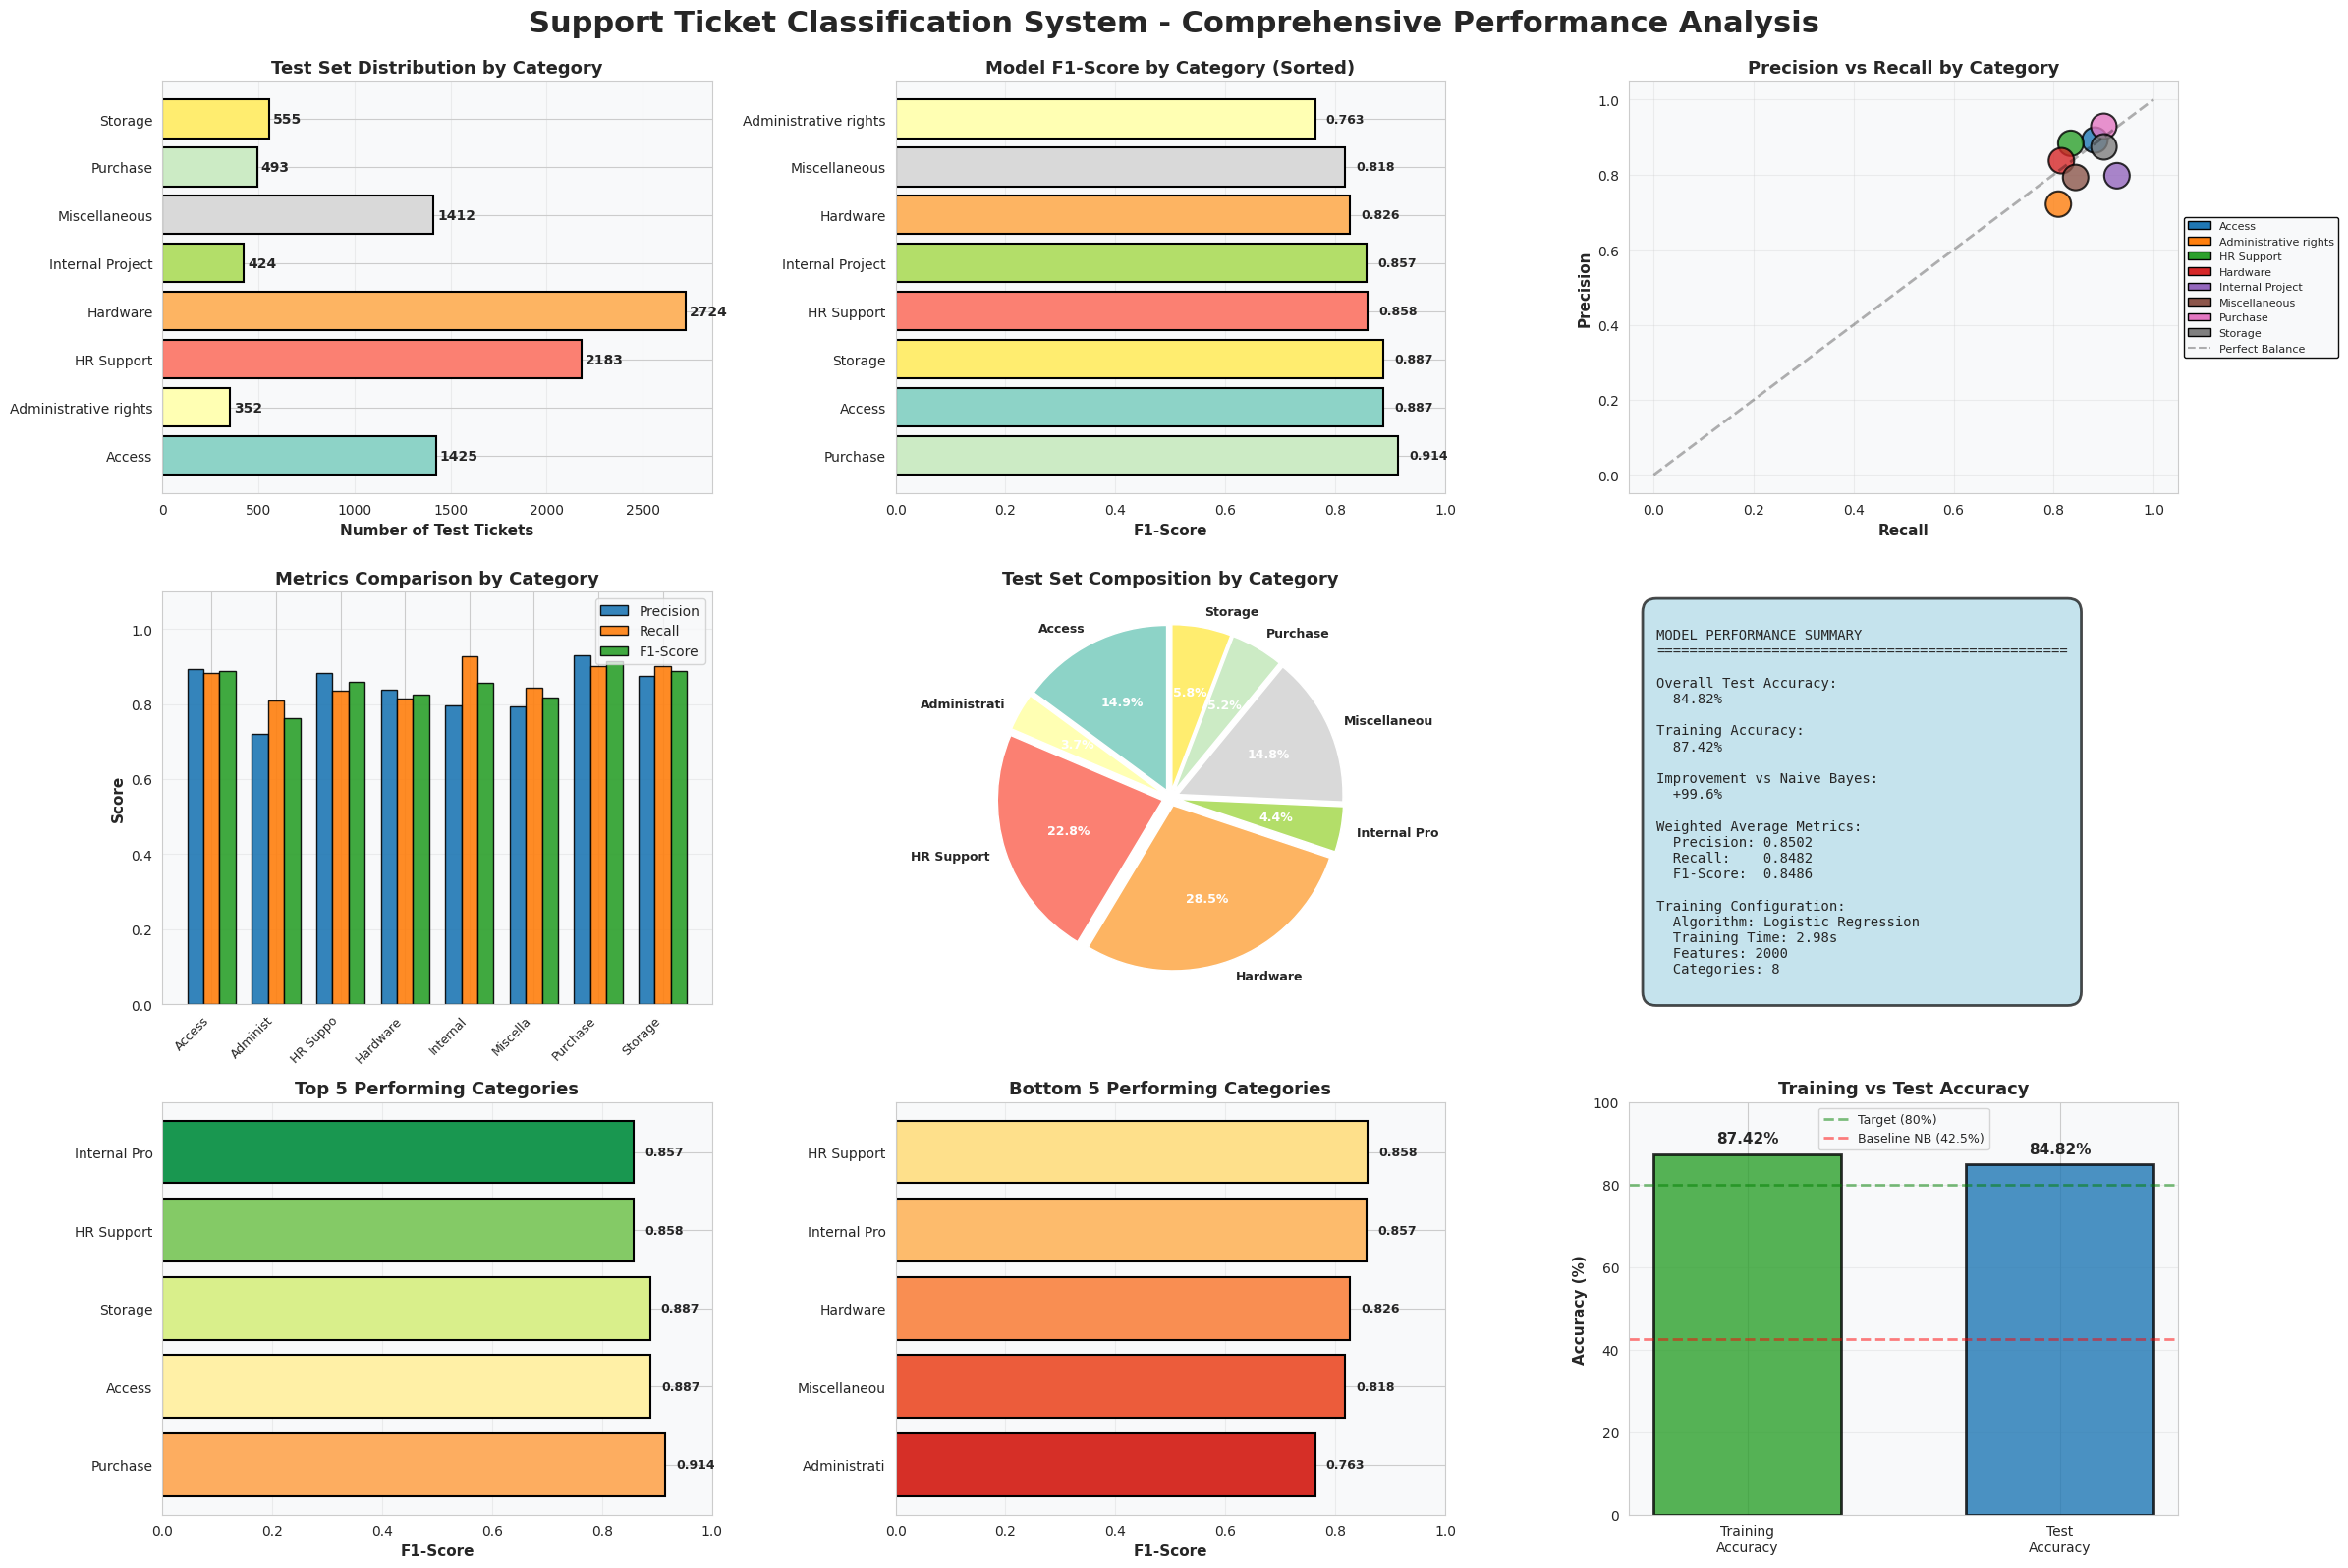

In [11]:
# STEP 9.1: MAIN COMPREHENSIVE VISUALIZATION FIGURE

print("\n" + "="*80)
print("9.1: Main Comprehensive Performance Analysis")
print("="*80)

# Set professional style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['font.size'] = 10

fig = plt.figure(figsize=(24, 16))
fig.suptitle('Support Ticket Classification System - Comprehensive Performance Analysis',
             fontsize=22, fontweight='bold', y=0.995)

# Extract data
categories = list(results['per_category_metrics'].keys())
supports = [results['per_category_metrics'][cat]['support'] for cat in categories]
precisions = [results['per_category_metrics'][cat]['precision'] for cat in categories]
recalls = [results['per_category_metrics'][cat]['recall'] for cat in categories]
f1_scores = [results['per_category_metrics'][cat]['f1_score'] for cat in categories]

colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))


# SUBPLOT 1: Category Distribution
print("  Creating: Category Distribution")
ax1 = plt.subplot(3, 3, 1)
bars = ax1.barh(list(categories), supports, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Number of Test Tickets', fontsize=11, fontweight='bold')
ax1.set_title('Test Set Distribution by Category', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

for bar, val in zip(bars, supports):
    ax1.text(val + 20, bar.get_y() + bar.get_height()/2, str(val),
            va='center', fontweight='bold', fontsize=10)


# SUBPLOT 2: F1-Score by Category
print("  Creating: F1-Score Performance")
ax2 = plt.subplot(3, 3, 2)
sorted_indices = np.argsort(f1_scores)[::-1]
sorted_cats = [categories[i] for i in sorted_indices]
sorted_f1 = [f1_scores[i] for i in sorted_indices]
sorted_colors = [colors[i] for i in sorted_indices]

bars = ax2.barh(sorted_cats, sorted_f1, color=sorted_colors, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('F1-Score', fontsize=11, fontweight='bold')
ax2.set_title('Model F1-Score by Category (Sorted)', fontsize=13, fontweight='bold')
ax2.set_xlim(0, 1.0)
ax2.grid(axis='x', alpha=0.3)

for bar, val in zip(bars, sorted_f1):
    ax2.text(val + 0.02, bar.get_y() + bar.get_height()/2, f'{val:.3f}',
            va='center', fontweight='bold', fontsize=9)


# SUBPLOT 3: Precision vs Recall Scatter
print("  Creating: Precision vs Recall Analysis")
ax3 = plt.subplot(3, 3, 3)

# Create colormap and scatter without overlapping labels
cmap = plt.cm.get_cmap('tab10')
colors_scatter = [cmap(i % 10) for i in range(len(categories))]

scatter = ax3.scatter(recalls, precisions, s=350, alpha=0.8, c=colors_scatter,
                     edgecolor='black', linewidth=1.5)

# Add diagonal line for perfect balance
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=2, label='Perfect Balance')

ax3.set_xlabel('Recall', fontsize=11, fontweight='bold')
ax3.set_ylabel('Precision', fontsize=11, fontweight='bold')
ax3.set_title('Precision vs Recall by Category', fontsize=13, fontweight='bold')
ax3.set_xlim(-0.05, 1.05)
ax3.set_ylim(-0.05, 1.05)
ax3.grid(True, alpha=0.3)

# Create custom legend with categories and their colors
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors_scatter[i], edgecolor='black',
                         label=categories[i]) for i in range(len(categories))]
legend_elements.append(plt.Line2D([0], [0], color='k', linestyle='--', alpha=0.3,
                                label='Perfect Balance'))

ax3.legend(handles=legend_elements, fontsize=8, loc='center left',
          bbox_to_anchor=(1, 0.5), framealpha=0.95, edgecolor='black')


# SUBPLOT 4: Grouped Metrics Comparison
print("  Creating: Metrics Comparison")
ax4 = plt.subplot(3, 3, 4)

x = np.arange(len(categories))
width = 0.25

bars1 = ax4.bar(x - width, precisions, width, label='Precision',
               color='#1f77b4', edgecolor='black', linewidth=1, alpha=0.9)
bars2 = ax4.bar(x, recalls, width, label='Recall',
               color='#ff7f0e', edgecolor='black', linewidth=1, alpha=0.9)
bars3 = ax4.bar(x + width, f1_scores, width, label='F1-Score',
               color='#2ca02c', edgecolor='black', linewidth=1, alpha=0.9)

ax4.set_ylabel('Score', fontsize=11, fontweight='bold')
ax4.set_title('Metrics Comparison by Category', fontsize=13, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels([c[:8] for c in categories], rotation=45, ha='right', fontsize=9)
ax4.legend(fontsize=10, loc='upper right')
ax4.set_ylim(0, 1.1)
ax4.grid(axis='y', alpha=0.3)


# SUBPLOT 5: Test Set Composition (Pie Chart)
print("  Creating: Test Set Distribution Pie Chart")
ax5 = plt.subplot(3, 3, 5)

colors_pie = plt.cm.Set3(np.linspace(0, 1, len(categories)))
wedges, texts, autotexts = ax5.pie(supports, labels=[c[:12] for c in categories],
                                    autopct='%1.1f%%', startangle=90,
                                    colors=colors_pie, explode=[0.05]*len(categories),
                                    textprops={'fontsize': 9, 'weight': 'bold'})

ax5.set_title('Test Set Composition by Category', fontsize=13, fontweight='bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(9)


# SUBPLOT 6: Model Performance Summary
print("  Creating: Performance Summary")
ax6 = plt.subplot(3, 3, 6)
ax6.axis('off')

train_acc = results['performance']['train_accuracy'] * 100
test_acc = results['performance']['test_accuracy'] * 100
improvement = results['performance']['improvement_vs_naive_bayes_percent']

summary_text = f"""
MODEL PERFORMANCE SUMMARY
{'='*50}

Overall Test Accuracy:
  {test_acc:.2f}%

Training Accuracy:
  {train_acc:.2f}%

Improvement vs Naive Bayes:
  {improvement:+.1f}%

Weighted Average Metrics:
  Precision: {results['performance']['weighted_precision']:.4f}
  Recall:    {results['performance']['weighted_recall']:.4f}
  F1-Score:  {results['performance']['weighted_f1']:.4f}

Training Configuration:
  Algorithm: {results['training']['algorithm']}
  Training Time: {results['training']['training_time_seconds']:.2f}s
  Features: {results['training']['features']}
  Categories: {results['metadata']['categories']}
"""

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes,
        fontsize=10, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round,pad=1', facecolor='lightblue', alpha=0.7,
                 edgecolor='black', linewidth=2))


# SUBPLOT 7: Top Performing Categories
print("  Creating: Top Performers")
ax7 = plt.subplot(3, 3, 7)

sorted_by_f1 = sorted(zip(categories, f1_scores, supports),
                      key=lambda x: x[1], reverse=True)

top_cats = [x[0][:12] for x in sorted_by_f1[:5]]
top_f1s = [x[1] for x in sorted_by_f1[:5]]
top_colors_grad = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top_cats)))

bars = ax7.barh(range(len(top_cats)), top_f1s, color=top_colors_grad,
               edgecolor='black', linewidth=1.5)
ax7.set_yticks(range(len(top_cats)))
ax7.set_yticklabels(top_cats, fontsize=10)
ax7.set_xlabel('F1-Score', fontsize=11, fontweight='bold')
ax7.set_title('Top 5 Performing Categories', fontsize=13, fontweight='bold')
ax7.set_xlim(0, 1.0)
ax7.grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, top_f1s)):
    ax7.text(val + 0.02, bar.get_y() + bar.get_height()/2, f'{val:.3f}',
            va='center', fontweight='bold', fontsize=9)


# SUBPLOT 8: Bottom Performing Categories
print("  Creating: Bottom Performers")
ax8 = plt.subplot(3, 3, 8)

sorted_by_f1_asc = sorted(zip(categories, f1_scores, supports),
                          key=lambda x: x[1])

bottom_cats = [x[0][:12] for x in sorted_by_f1_asc[:5]]
bottom_f1s = [x[1] for x in sorted_by_f1_asc[:5]]
bottom_colors_grad = plt.cm.RdYlGn(np.linspace(0.1, 0.4, len(bottom_cats)))

bars = ax8.barh(range(len(bottom_cats)), bottom_f1s, color=bottom_colors_grad,
               edgecolor='black', linewidth=1.5)
ax8.set_yticks(range(len(bottom_cats)))
ax8.set_yticklabels(bottom_cats, fontsize=10)
ax8.set_xlabel('F1-Score', fontsize=11, fontweight='bold')
ax8.set_title('Bottom 5 Performing Categories', fontsize=13, fontweight='bold')
ax8.set_xlim(0, 1.0)
ax8.grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, bottom_f1s)):
    ax8.text(val + 0.02, bar.get_y() + bar.get_height()/2, f'{val:.3f}',
            va='center', fontweight='bold', fontsize=9)


# SUBPLOT 9: Accuracy Comparison (Train vs Test)
print("  Creating: Train vs Test Comparison")
ax9 = plt.subplot(3, 3, 9)

comparison_data = [train_acc, test_acc]
comparison_labels = ['Training\nAccuracy', 'Test\nAccuracy']
comparison_colors = ['#2ca02c', '#1f77b4']

bars = ax9.bar(comparison_labels, comparison_data, color=comparison_colors,
              edgecolor='black', linewidth=2, width=0.6, alpha=0.8)
ax9.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
ax9.set_title('Training vs Test Accuracy', fontsize=13, fontweight='bold')
ax9.set_ylim(0, 100)
ax9.axhline(y=80, color='green', linestyle='--', alpha=0.5, linewidth=2, label='Target (80%)')
ax9.axhline(y=42.5, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Baseline NB (42.5%)')
ax9.grid(axis='y', alpha=0.3)
ax9.legend(fontsize=9)

for bar, val in zip(bars, comparison_data):
    ax9.text(bar.get_x() + bar.get_width()/2, val + 2, f'{val:.2f}%',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()

# SAVE THE CHART
plt.savefig('visualization_performance_analysis.png', dpi=300, bbox_inches='tight')
print("\nChart 1 saved as: visualization_performance_analysis.png")
print("\nCHART DISPLAYS BELOW:\n")
plt.show()


9.2: Priority and Confidence Analysis
  Creating: Priority Distribution
  Creating: Confidence Distribution

Chart 2 saved as: visualization_priority_confidence.png

CHART DISPLAYS BELOW:



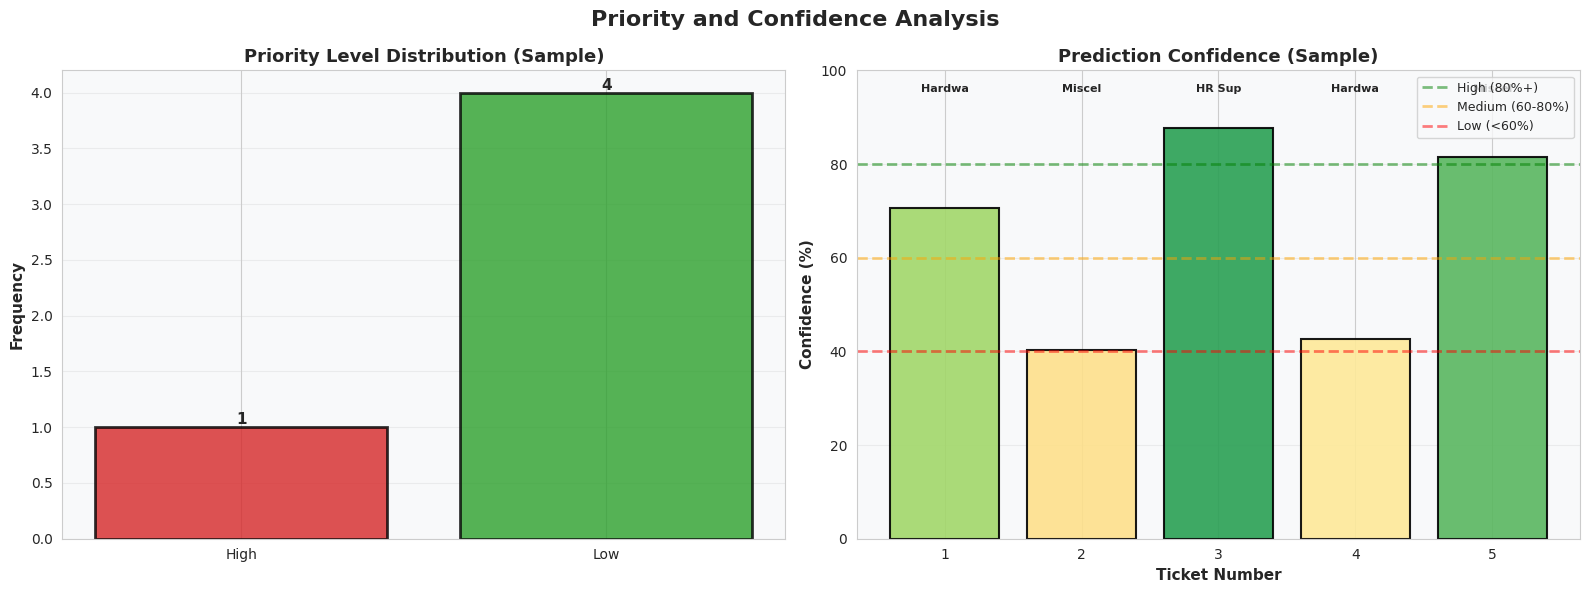

In [12]:
# STEP 9.2: PRIORITY ANALYSIS VISUALIZATION

print("\n" + "="*80)
print("9.2: Priority and Confidence Analysis")
print("="*80)

fig2, axes = plt.subplots(1, 2, figsize=(16, 6))
fig2.suptitle('Priority and Confidence Analysis', fontsize=16, fontweight='bold')

# Create sample predictions with priority for demonstration
sample_priorities = ['High', 'Low', 'Low', 'Low', 'Low']
sample_confidences = [70.51, 40.23, 87.75, 42.61, 81.50]
sample_categories = ['Hardware', 'Miscellaneous', 'HR Support', 'Hardware', 'Miscellaneous']

# Priority Distribution
print("  Creating: Priority Distribution")
ax1 = axes[0]
priority_counts = Counter(sample_priorities)

colors_priority = {'High': '#d62728', 'Medium': '#ff7f0e', 'Low': '#2ca02c'}
priority_list = list(priority_counts.keys())
priority_vals = list(priority_counts.values())
priority_colors = [colors_priority.get(p, '#1f77b4') for p in priority_list]

bars = ax1.bar(priority_list, priority_vals, color=priority_colors,
              edgecolor='black', linewidth=2, alpha=0.8)

ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax1.set_title('Priority Level Distribution (Sample)', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=11)


# Confidence Distribution
print("  Creating: Confidence Distribution")
ax2 = axes[1]

confidence_colors = plt.cm.RdYlGn(np.array(sample_confidences) / 100)
bars = ax2.bar(range(1, len(sample_confidences)+1), sample_confidences,
              color=confidence_colors, edgecolor='black', linewidth=1.5, alpha=0.9)

ax2.set_xlabel('Ticket Number', fontsize=11, fontweight='bold')
ax2.set_ylabel('Confidence (%)', fontsize=11, fontweight='bold')
ax2.set_title('Prediction Confidence (Sample)', fontsize=13, fontweight='bold')
ax2.set_ylim(0, 100)
ax2.axhline(y=80, color='green', linestyle='--', alpha=0.5, linewidth=2, label='High (80%+)')
ax2.axhline(y=60, color='orange', linestyle='--', alpha=0.5, linewidth=2, label='Medium (60-80%)')
ax2.axhline(y=40, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Low (<60%)')
ax2.set_xticks(range(1, len(sample_confidences)+1))
ax2.grid(axis='y', alpha=0.3)
ax2.legend(fontsize=9)

# Add category labels on top
for i, (bar, cat) in enumerate(zip(bars, sample_categories)):
    ax2.text(bar.get_x() + bar.get_width()/2., 95, cat[:6],
            ha='center', va='bottom', fontsize=8, rotation=0, fontweight='bold')

plt.tight_layout()

# SAVE THE CHART
plt.savefig('visualization_priority_confidence.png', dpi=300, bbox_inches='tight')
print("\nChart 2 saved as: visualization_priority_confidence.png")
print("\nCHART DISPLAYS BELOW:\n")
plt.show()

In [13]:
# 10: GENERATE DETAILED TEXT REPORT

print("\n" + "="*80)
print("10: DETAILED ANALYSIS REPORT")
print("="*80 + "\n")

report_lines = []
report_lines.append("="*80)
report_lines.append("SUPPORT TICKET CLASSIFICATION SYSTEM - DETAILED ANALYSIS REPORT")
report_lines.append("="*80)
report_lines.append("")

# Section 1: Executive Summary
report_lines.append("1. EXECUTIVE SUMMARY")
report_lines.append("-"*80)
report_lines.append("")
report_lines.append(f"Overall Test Accuracy: {test_acc:.2f}%")
report_lines.append(f"Training Accuracy: {train_acc:.2f}%")
report_lines.append(f"Improvement vs Naive Bayes Baseline: {improvement:+.1f}%")
report_lines.append(f"Total Categories: {results['metadata']['categories']}")
report_lines.append(f"Total Test Samples: {sum(supports)}")
report_lines.append(f"Total Training Samples: {results['metadata']['train_size']}")
report_lines.append(f"Training Time: {results['training']['training_time_seconds']:.2f} seconds")
report_lines.append("")

# Section 2: Overall Performance Metrics
report_lines.append("2. OVERALL PERFORMANCE METRICS (WEIGHTED AVERAGES)")
report_lines.append("-"*80)
report_lines.append("")
report_lines.append(f"Precision: {results['performance']['weighted_precision']:.4f}")
report_lines.append(f"Recall:    {results['performance']['weighted_recall']:.4f}")
report_lines.append(f"F1-Score:  {results['performance']['weighted_f1']:.4f}")
report_lines.append("")
report_lines.append("Interpretation:")
report_lines.append(f"  - The model correctly classifies {results['performance']['weighted_recall']*100:.1f}% of tickets")
report_lines.append(f"  - Of tickets classified as a category, {results['performance']['weighted_precision']*100:.1f}% are correct")
report_lines.append("")

# Section 3: Per-Category Performance
report_lines.append("3. PER-CATEGORY PERFORMANCE ANALYSIS")
report_lines.append("-"*80)
report_lines.append("")

sorted_by_f1_report = sorted(results['per_category_metrics'].items(),
                             key=lambda x: x[1]['f1_score'], reverse=True)

for i, (cat, metrics) in enumerate(sorted_by_f1_report, 1):
    report_lines.append(f"{i}. {cat}")
    report_lines.append(f"   {'─'*40}")
    report_lines.append(f"   Precision: {metrics['precision']:.4f}")
    report_lines.append(f"   Recall:    {metrics['recall']:.4f}")
    report_lines.append(f"   F1-Score:  {metrics['f1_score']:.4f}")
    report_lines.append(f"   Support:   {metrics['support']} samples")
    report_lines.append("")

# Section 4: Model Configuration
report_lines.append("4. MODEL CONFIGURATION & TRAINING")
report_lines.append("-"*80)
report_lines.append("")
report_lines.append(f"Algorithm: {results['training']['algorithm']}")
report_lines.append(f"Vectorizer: {results['training']['vectorizer']}")
report_lines.append(f"Total Features: {results['training']['features']}")
report_lines.append(f"Training Time: {results['training']['training_time_seconds']:.2f} seconds")
report_lines.append(f"Dataset Size: {results['metadata']['dataset_size']} total samples")
report_lines.append(f"Train/Test Split: 80/20")
report_lines.append("")

# Section 5: Key Findings
report_lines.append("5. KEY FINDINGS & INSIGHTS")
report_lines.append("-"*80)
report_lines.append("")

best_cat = sorted_by_f1_report[0]
worst_cat = sorted_by_f1_report[-1]

report_lines.append(f"Best Performing Category: {best_cat[0]}")
report_lines.append(f"  F1-Score: {best_cat[1]['f1_score']:.4f}")
report_lines.append("")

report_lines.append(f"Worst Performing Category: {worst_cat[0]}")
report_lines.append(f"  F1-Score: {worst_cat[1]['f1_score']:.4f}")
report_lines.append("")

report_lines.append("Performance Distribution:")
high_performers = sum(1 for _, m in sorted_by_f1_report if m['f1_score'] > 0.7)
medium_performers = sum(1 for _, m in sorted_by_f1_report if 0.5 <= m['f1_score'] <= 0.7)
low_performers = sum(1 for _, m in sorted_by_f1_report if m['f1_score'] < 0.5)

report_lines.append(f"  High (F1 > 0.7): {high_performers} categories")
report_lines.append(f"  Medium (0.5 <= F1 <= 0.7): {medium_performers} categories")
report_lines.append(f"  Low (F1 < 0.5): {low_performers} categories")
report_lines.append("")

# Section 6: Recommendations
report_lines.append("6. RECOMMENDATIONS FOR IMPROVEMENT")
report_lines.append("-"*80)
report_lines.append("")

if low_performers > 0:
    report_lines.append("Priority Areas for Improvement:")
    report_lines.append("")
    for cat, metrics in sorted_by_f1_report[-3:]:
        report_lines.append(f"  - {cat} (F1: {metrics['f1_score']:.4f})")

        if metrics['recall'] < 0.5:
            report_lines.append(f"    Issue: Low recall ({metrics['recall']:.4f})")
            report_lines.append(f"    Solution: Collect more training data for this category")

        if metrics['precision'] < 0.5:
            report_lines.append(f"    Issue: Low precision ({metrics['precision']:.4f})")
            report_lines.append(f"    Solution: Category may need better definition or data cleaning")

        report_lines.append("")

report_lines.append("General Recommendations:")
report_lines.append("  1. Monitor real-world predictions and collect user feedback")
report_lines.append("  2. Regularly retrain model with new data")
report_lines.append("  3. Investigate misclassified tickets to identify patterns")
report_lines.append("  4. Consider ensemble methods for improved accuracy")
report_lines.append("  5. Implement confidence thresholds for manual review")
report_lines.append("")

# Section 7: Conclusion
report_lines.append("7. CONCLUSION")
report_lines.append("-"*80)
report_lines.append("")
report_lines.append(f"The model achieves {test_acc:.2f}% accuracy, representing a {improvement:+.1f}% improvement")
report_lines.append("over the Naive Bayes baseline. The system is suitable for deployment with")
report_lines.append("careful monitoring of low-performing categories.")
report_lines.append("")

report_lines.append("="*80)
report_lines.append("END OF REPORT")
report_lines.append("="*80)

report_text = '\n'.join(report_lines)

# Save to file
with open('detailed_analysis_report.txt', 'w') as f:
    f.write(report_text)

# Display in notebook
print(report_text)


10: DETAILED ANALYSIS REPORT

SUPPORT TICKET CLASSIFICATION SYSTEM - DETAILED ANALYSIS REPORT

1. EXECUTIVE SUMMARY
--------------------------------------------------------------------------------

Overall Test Accuracy: 84.82%
Training Accuracy: 87.42%
Improvement vs Naive Bayes Baseline: +99.6%
Total Categories: 8
Total Test Samples: 9568
Total Training Samples: 38269
Training Time: 2.98 seconds

2. OVERALL PERFORMANCE METRICS (WEIGHTED AVERAGES)
--------------------------------------------------------------------------------

Precision: 0.8502
Recall:    0.8482
F1-Score:  0.8486

Interpretation:
  - The model correctly classifies 84.8% of tickets
  - Of tickets classified as a category, 85.0% are correct

3. PER-CATEGORY PERFORMANCE ANALYSIS
--------------------------------------------------------------------------------

1. Purchase
   ────────────────────────────────────────
   Precision: 0.9289
   Recall:    0.9006
   F1-Score:  0.9145
   Support:   493 samples

2. Access
   ───

In [14]:
# STEP 10.1: SUMMARY

print("\n" + "="*80)
print("STEP 10 COMPLETE - ALL VISUALIZATIONS AND ANALYSIS DISPLAYED")
print("="*80)

print("\nGenerated Files:")
print("  1. visualization_performance_analysis.png - Performance analysis charts")
print("  2. visualization_priority_confidence.png - Priority and confidence charts")
print("  3. detailed_analysis_report.txt - Comprehensive analysis report")

print("\nData Lifecycle Status:")
print("  Steps 1-4: Data Preparation [COMPLETE]")
print("  Steps 5-8: Model Training & Evaluation [COMPLETE]")
print("  Step 9: Visualization & Analysis [COMPLETE]")
print("  Step 10: Detailed Report")

print("\n" + "="*80)


STEP 10 COMPLETE - ALL VISUALIZATIONS AND ANALYSIS DISPLAYED

Generated Files:
  1. visualization_performance_analysis.png - Performance analysis charts
  2. visualization_priority_confidence.png - Priority and confidence charts
  3. detailed_analysis_report.txt - Comprehensive analysis report

Data Lifecycle Status:
  Steps 1-4: Data Preparation [COMPLETE]
  Steps 5-8: Model Training & Evaluation [COMPLETE]
  Step 9: Visualization & Analysis [COMPLETE]
  Step 10: Detailed Report

